In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import netCDF4 as nc
import geopandas as gpd

import xarray

import rasterio
from rasterio.transform import from_origin
import pandas as pd
from scipy.interpolate import griddata

## Prediction data


In [53]:
#read in the predicted dataset
#src = "/Users/jules/Documents/github/starkregen_graphcast/1709036507_predicted_dataset_small_model_input_pressure_and_no_pressure_combined_24_02.nc"
src = "possible_3_steps_predictions_20_02.nc"
with open(src, "rb",) as f:
    predicted_dataset = xarray.load_dataset(f).compute()

In [ ]:
predicted_dataset.time

In [54]:

# Define latitude and longitude bounds for Germany
lat_bounds = (44.5, 55.0)
lon_bounds = (2.5, 15.0)

#lat_bounds = (30.0, 55.0)
#lon_bounds = (0.0, 30.0)



# Select data for Germany
germany_data = predicted_dataset.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
#print(germany_data)
# get total precipitation
precipitation = germany_data.total_precipitation_6hr
# select at the diffrerent time steps

print(precipitation.time)





<xarray.DataArray 'time' (time: 3)>
array([21600000000000, 43200000000000, 64800000000000], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 06:00:00 12:00:00 18:00:00


In [55]:
percipitation_6h = precipitation.sel(time="06:00:00")
percipitation_12h = precipitation.sel(time="12:00:00")
percipitation_18h = precipitation.sel(time="18:00:00")

In [56]:
# convert all to csv
percipitation_6h.to_dataframe().to_csv("percipitation_6h.csv")
percipitation_12h.to_dataframe().to_csv("percipitation_12h.csv")
percipitation_18h.to_dataframe().to_csv("percipitation_18h.csv")

In [ ]:
"""# to csv
precipitation.to_dataframe().to_csv("precipitation.csv")
# only lat and lon and precipitation csv    
germany_data.total_precipitation_6hr.sel(time="06:00:00", batch=0).to_dataframe().to_csv("germany_data.csv")"""

In [ ]:
"""# interpolate for arcgis online
# WORKS

# Angenommene Daten aus deinem xarray.DataArray
lon = germany_data.lon.values
lat = germany_data.lat.values
precipitation_values = germany_data.total_precipitation_6hr.isel(time=0, batch=0).values

# Erzeuge ein Gitter für die Interpolation
lon_grid, lat_grid = np.meshgrid(np.linspace(lon.min(), lon.max(), 100), 
                                 np.linspace(lat.min(), lat.max(), 100))

# Flache Arrays für griddata
points = np.transpose([np.tile(lat, len(lon)), np.repeat(lon, len(lat))])
values = precipitation_values.flatten()

# Führe die Interpolation durch
grid_z0 = griddata(points, values, (lat_grid, lon_grid), method='cubic')

# Erstelle einen DataFrame mit den interpolierten Daten
df_interp = pd.DataFrame({
    'Latitude': lat_grid.flatten(),
    'Longitude': lon_grid.flatten(),
    'Precipitation': grid_z0.flatten()
})

# Entferne NaN-Werte, die außerhalb deiner ursprünglichen Datenpunkte entstehen könnten
df_interp.dropna(inplace=True)

# Exportiere die interpolierten Daten in eine CSV-Datei
df_interp.to_csv("interpolated_precipitation.csv", index=False)

"""

In [43]:
# make it for arcgis online for visualization
# Erstelle ein Raster-Array basierend auf den Niederschlagsdaten
precipitation = germany_data.total_precipitation_6hr.isel(time=0, batch=0)

# Erstelle ein GeoTIFF
transform = from_origin(5.5, 55.0, 0.25, 0.25) # Startpunkt (oben links), Pixelgröße in Lon/Lat
with rasterio.open(
    'precipitation_raster.tif', 'w', driver='GTiff',
    height=precipitation.shape[0], width=precipitation.shape[1],
    count=1, dtype=str(precipitation.dtype),
    crs='+proj=latlong',  # Definiere das Koordinatenreferenzsystem
    transform=transform,
) as dst:
    dst.write(precipitation.values, 1)

In [ ]:
print(len(lat_bounds))
print(len(lon_bounds))

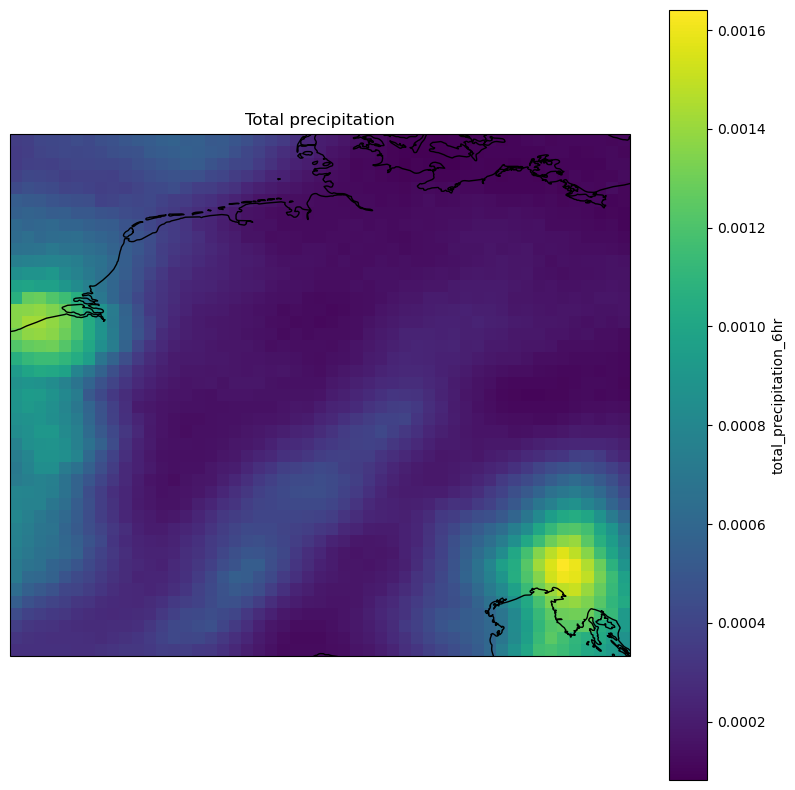

In [58]:
# plot the precipitation
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
percipitation_18h.plot(ax=ax, transform=ccrs.PlateCarree())
plt.title("Total precipitation")
plt.show()


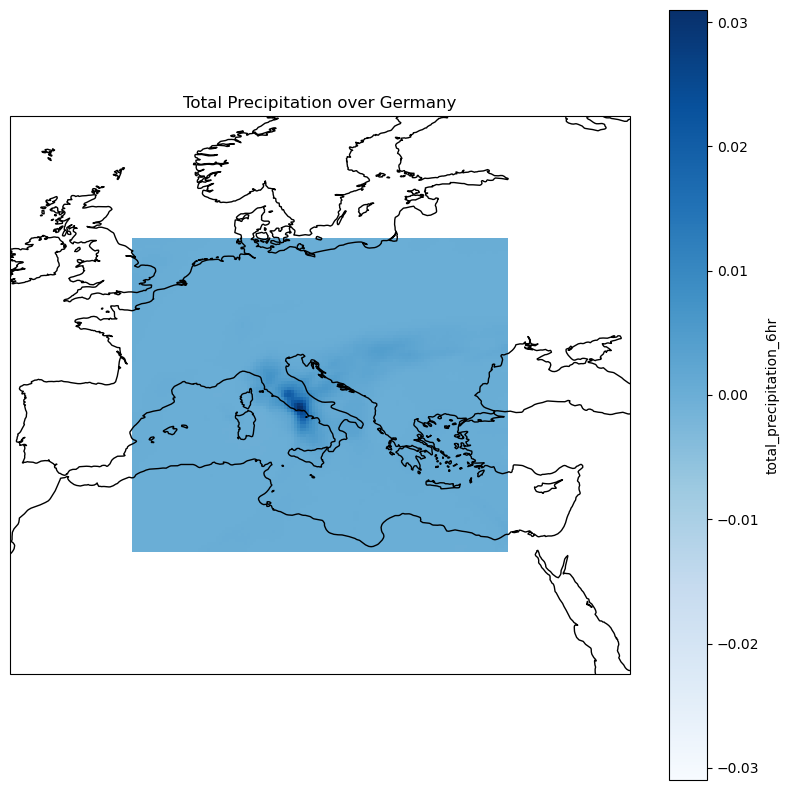

In [45]:

# Define the map projection and create a figure
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the plot to slightly beyond the bounds of Germany for context
# Here, we add/subtract a small value to the bounds to provide some padding around Germany
margin = 10  # You can adjust the margin value to zoom in or out
ax.set_extent([lon_bounds[0] - margin, lon_bounds[1] + margin, 
               lat_bounds[0] - margin, lat_bounds[1] + margin], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()

# Plot the precipitation data
percipitation_6h.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Set the title and show the plot
plt.title("Total Precipitation over Germany")
plt.show()


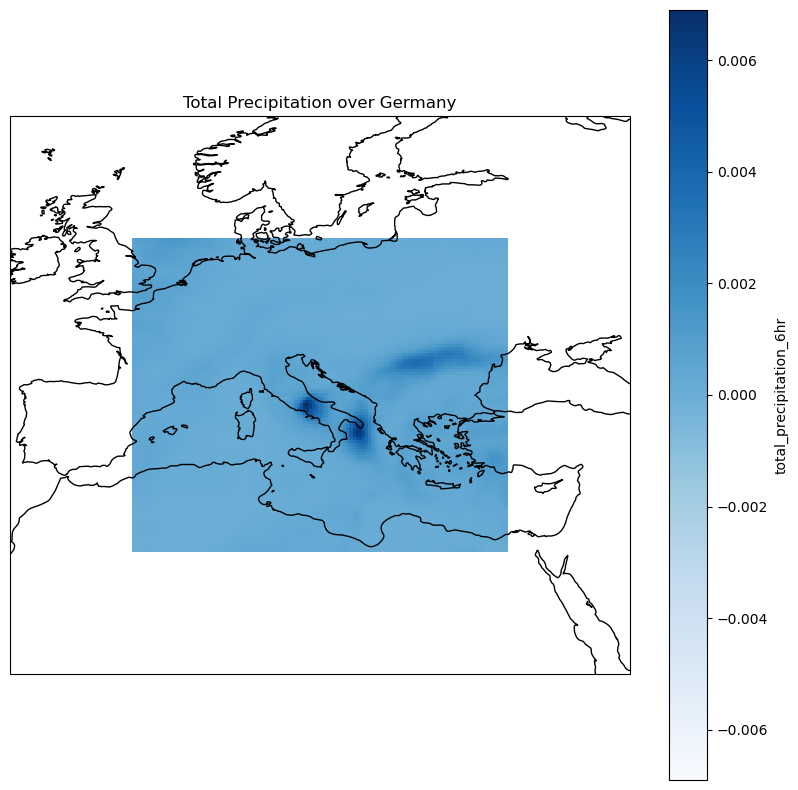

In [46]:

# Define the map projection and create a figure
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the plot to slightly beyond the bounds of Germany for context
# Here, we add/subtract a small value to the bounds to provide some padding around Germany
margin = 10  # You can adjust the margin value to zoom in or out
ax.set_extent([lon_bounds[0] - margin, lon_bounds[1] + margin, 
               lat_bounds[0] - margin, lat_bounds[1] + margin], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()

# Plot the precipitation data
percipitation_12h.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Set the title and show the plot
plt.title("Total Precipitation over Germany")
plt.show()


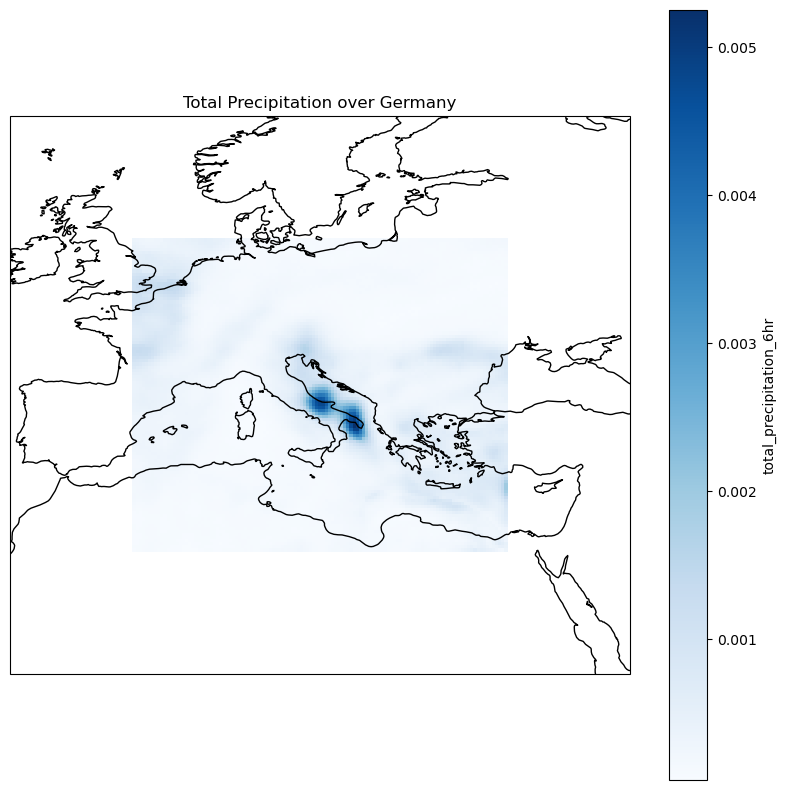

In [47]:

# Define the map projection and create a figure
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the plot to slightly beyond the bounds of Germany for context
# Here, we add/subtract a small value to the bounds to provide some padding around Germany
margin = 10  # You can adjust the margin value to zoom in or out
ax.set_extent([lon_bounds[0] - margin, lon_bounds[1] + margin, 
               lat_bounds[0] - margin, lat_bounds[1] + margin], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()

# Plot the precipitation data
percipitation_18h.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Set the title and show the plot
plt.title("Total Precipitation over Germany")
plt.show()


In [ ]:


# Load the shapefile for Germany
germany_shapefile = gpd.read_file('/Users/jules/Downloads/Germany_shapefile/de_100km.shp')

# Define the map projection and create a figure
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the plot to slightly beyond the bounds of Germany for context
margin = 10  # Adjust the margin value if necessary
ax.set_extent([lon_bounds[0] - margin, lon_bounds[1] + margin, 
               lat_bounds[0] - margin, lat_bounds[1] + margin], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()

# Plot the outline of Germany using the shapefile
germany_shapefile.plot(ax=ax, edgecolor='black', transform=ccrs.PlateCarree())

# Plot the precipitation data
precipitation.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Set the title and show the plot
plt.title("Total Precipitation over Germany")
plt.show()


## Input

In [ ]:
precipitation

In [ ]:
demo_perpipitation

In [ ]:
demo_input_src = "/Users/jules/Documents/github/starkregen_graphcast/data/datasets/source-era5_date-2022-01-01_res-0.25_levels-37_steps-01.nc"
# Define latitude and longitude bounds for Germany
lat_bounds = (47.5, 55.0)
lon_bounds = (5.5, 15.0)

with open(demo_input_src, "rb",) as f:
    demo_input_dataset = xarray.load_dataset(f).compute()

demo_ger_perpipitation = demo_input_dataset.total_precipitation_6hr.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds)).sel(time="06:00:00")

In [ ]:
demo_ger_perpipitation_time = demo_input_dataset.time
#print(demo_ger_perpipitation_time)

demo_ger_perpipitation_time6 = demo_ger_perpipitation_time.sel(time="06:00:00", method="nearest")
print(demo_ger_perpipitation_time6)

In [ ]:
#plot
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
demo_ger_perpipitation.plot(ax=ax, transform=ccrs.PlateCarree())
plt.title("Total precipitation")

In [ ]:
# Prediction input from grpahtcast demo 
demo_input_path = "/Users/jules/Documents/github/starkregen_graphcast/data/datasets/source-era5_date-2022-01-01_res-0.25_levels-37_steps-01.nc"
demo_input_nc = nc.Dataset(demo_input_path, 'r')
lons_demo = demo_input_nc.variables['lon'][:]
lats_demo = demo_input_nc.variables['lat'][:]
time_demo = demo_input_nc.variables['time'][:]
lsm_demo = demo_input_nc.variables['land_sea_mask'][:]
t2m_demo = demo_input_nc.variables['2m_temperature'][:]
msl_demo = demo_input_nc.variables['mean_sea_level_pressure'][:]
tp_demo = demo_input_nc.variables['total_precipitation_6hr'][:]
tisr_demo = demo_input_nc.variables['toa_incident_solar_radiation'][:]
z_demo = demo_input_nc.variables['geopotential'][:]
u10_demo = demo_input_nc.variables['10m_u_component_of_wind'][:]
v10_demo = demo_input_nc.variables['10m_v_component_of_wind'][:]

1. Geographical Map: Plotting Temperature (2m Temperature)

In [ ]:

# Assuming lons_demo, lats_demo, and t2m_demo are loaded as described

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Assuming t2m_demo is 2D (latitude x longitude), and you have a specific time index (e.g., 0)
temperature = t2m_demo[0].squeeze()  # Adjust index for time step as needed and remove singleton dimension
temperature_2d = temperature.reshape(lats_demo.shape)  # Reshape to 2D
contour = ax.contourf(lons_demo, lats_demo, temperature_2d, transform=ccrs.PlateCarree(), cmap='coolwarm')

plt.colorbar(contour, ax=ax, orientation='vertical')
plt.title('2m Temperature')
plt.show()

In [ ]:
# Calculate global mean (simplistically, not accounting for area differences)
global_mean_temp = np.mean(t2m_demo, axis=(1, 2))  # Assuming t2m_demo is (time, lat, lon)

plt.figure(figsize=(10, 5))
plt.plot(time_demo, global_mean_temp)
plt.xlabel('Time')
plt.ylabel('Global Mean Temperature')
plt.title('Global Mean 2m Temperature Over Time')
plt.show()

In [ ]:
# Flatten the temperature data for a specific time step to get its distribution
temp_flat = tp_demo[0].flatten()  # Adjust index for time step as needed

plt.figure(figsize=(10, 5))
plt.hist(temp_flat, bins=10, color='blue', edgecolor='black')
plt.title('Distribution of 2m Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


In [ ]:

# Extract variables and compute mean values for the first time step
t2m_mean = np.mean(demo_input_nc.variables['2m_temperature'][0, :, :])
msl_mean = np.mean(demo_input_nc.variables['mean_sea_level_pressure'][0, :, :])
tp_mean = np.mean(demo_input_nc.variables['total_precipitation_6hr'][0, :, :])
u10_mean = np.mean(demo_input_nc.variables['10m_u_component_of_wind'][0, :, :])

# Close the dataset
demo_input_nc.close()

# Prepare data for radar chart
labels = np.array(['2m Temp', 'MSL Pressure', 'Precipitation', 'Wind Speed'])
stats = np.array([t2m_mean, msl_mean, tp_mean, u10_mean])

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats,[stats[0]]))  # Create a closed loop
angles += angles[:1]  # Complete the circle for the radar chart

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='red', alpha=0.25)
ax.plot(angles, stats, color='red', linewidth=2)  # Draw the outline of our data
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Climate Variables Overview')
plt.show()
